# (inverse) hourglass artefact of preprocessing

The proof of the pudding is in the eating! Does the normalization story hold up on real data? 

To disprove that the inverse hourglass pattern is an effect of phylogenetic distance, we have one within phylum comparison (zebrafish vs mouse), we have the lancet fish as a sort-of/almost outside phylum comparison, and we added the C. elegans as a real between phylum comparison. 

- The C. elegans data and the zebrafish data are from the paper "The mid-developmental transition and the evolution of animal body plans" with which the authors get an inverse hourglass.
- The lancet fish data comes from the "Amphioxus functional genomics and the origins of vertebrate gene regulation" paper in which they get an hourglass pattern between amphioxus, frog, chicken, and zebrafish.
- The mouse data comes from the EXPANDE project.



TODO:

peaks with a peak mid, distance with ortholog peaking

top5% highest variance/mean genes with normalization

In [1]:
import warnings

import qnorm
import scipy
import numpy as np
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
from scipy import stats
# from skmisc.loess import loess
from sklearn.metrics import r2_score
from multiprocessing import Pool

from util import gene_landscape, jensen_shannon_distance

In [2]:
# load metadata
samples = pd.read_table("../data/count_tables/samples.tsv", index_col=0)
descriptve2stage = {k: v for k, v in zip(samples["descriptive_name"], samples["stage"])}

assemblies = {
    "lancet fish" : "BraLan2",
    "C. elegans": "ce11",
    "zebra fish": "GRCz11",
    "D. melanogaster": "BDGP6.32",
    "mouse": "GRCm38.p6",
    "chicken": "galGal6",
    "X. tropicalis": "UCB_Xtro_10.0"
}

# load count tables
dfs_tpm = dict()
for name, assembly in assemblies.items():
    # load the TPM files
    dfs_tpm[name] = pd.read_table(f"../data/count_tables/{assembly}-TPM.tsv.gz", index_col=0)

    # take the average over stages
    dfs_tpm__molten = dfs_tpm[name].melt(ignore_index=False).reset_index()
    dfs_tpm__molten["stage"] = [descriptve2stage[x] for x in dfs_tpm__molten["variable"]]
    dfs_tpm[name] = dfs_tpm__molten.groupby(["gene", "stage"]).mean(numeric_only=True).reset_index().pivot(index="gene", columns="stage")
    
    # make sure the columns are ordered as in the samples file
    dfs_tpm[name].columns = [x for _, x in dfs_tpm[name].columns]
    dfs_tpm[name] = dfs_tpm[name][list(dict.fromkeys(samples[samples["assembly"] == assembly]["stage"]))]

In [3]:
dfs_tpm

{'lancet fish':            blastula       7hpf        8hpf      10hpf      11hpf      15hpf  \
 gene                                                                          
 BL00000    9.740316  11.226867    6.652047  13.045008  18.257569  37.786183   
 BL00001    0.410081   1.734221    0.388931   0.119014   0.084037   0.034605   
 BL00002  203.745817  83.095675  154.316715  10.266293   7.936123  24.295161   
 BL00003    0.000000   0.084031    0.054278   0.039215   0.114229   0.364020   
 BL00004    2.905266   3.086678    3.485346   8.625748   9.621171  10.029531   
 ...             ...        ...         ...        ...        ...        ...   
 BL97479    7.280129   5.938803    1.177395   1.705399   1.136793   1.041579   
 BL97480   47.136598  10.085025    8.803303   3.345357   4.007499   4.903431   
 BL97481    1.481661   0.426700    0.527482   1.091710   1.130623   0.511492   
 BL97482    0.000000   0.331083    0.419258   0.090325   0.686913   0.115587   
 BL97483    0.000000   0.

# Is RNA-seq homoscedastic or heteroscedastic?

Gene expression is heteroscedasctic. This means that genes with high expression also have high variance. This in effect results that without scaling, genes with high expression have a higher influence in e.g. our calculation of the correlation coefficient.

Since gene expression is heteroscedastic (see figure below), it is important to scale.

In [4]:
# fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=len(assemblies), sharey=True, sharex=True, dpi=300)
# # fig.suptitle("mean vs variance per gene and per species")

# for i, name in enumerate(assemblies.keys()):
#     ax = axes[i]

#     means = dfs_raw[name].mean(axis=1)
# #     means = dfs_cpm[name].mean(axis=1)
# #     variances = sklearn.preprocessing.minmax_scale(dfs_cpm[name], axis=1).var(axis=1)
#     variances = dfs_raw[name].var(axis=1)
# #     variances = dfs_cpm[name].var(axis=1)
    
#     ax.scatter(means, variances, s=0.001)
#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xticks([])
# #     ax.set_yticks([])
#     ax.set_title(name)
# #     ax.set_xlabel("mean expression of a gene")
# #     if i == 0:
# #         ax.set_ylabel("variance of expression of a gene")


In [5]:
# fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=1, sharey=True, sharex=True, dpi=300)
# # fig.suptitle("mean vs variance per gene and per species")

# for i, name in enumerate(assemblies.keys()):
#     means = dfs_cpm[name].mean(axis=1)
# #     means = sklearn.preprocessing.scale(dfs_cpm[name], axis=1).mean(axis=1)
#     variances = dfs_cpm[name].var(axis=1)
# #     variances = sklearn.preprocessing.minmax_scale(dfs_cpm[name], axis=1).var(axis=1)
#     variances = sklearn.preprocessing.scale(dfs_cpm[name], axis=1).var(axis=1)
    
#     axes.scatter(means, variances, s=0.1, label=name)
# axes.set_yscale('log')
# axes.set_xscale('log')
# #     ax.set_xticks([])
# #     ax.set_yticks([])
# #     ax.set_title(name)
# #     ax.set_xlabel("mean expression of a gene")
# #     if i == 0:
# #         ax.set_ylabel("variance of expression of a gene")


# gene pattern landscape

Just as the (cpm-normalized) xenopus data from the previous notebook, the gene expression patterns of these developing embryo's follow a similar pattern. Genes either get upregulated or downregulated over time. 

In [6]:
# # first we smoothen the data a bit by fitting it on a line by LOESS regression

# def get_loess_fits(df_expression, samples):
#     fits = []

#     stages = samples.loc[df_expression.columns]["hpf"].values

#     def loess_fit(gene, xs, ys):
#         loess_options = {"span": 0.4, "degree": 2, "surface":'direct'}

#         xs = xs.flatten()
#         ys = ys.flatten()
        
#         # ignore all the numpy deprecation warnings in loess
#         with warnings.catch_warnings():
#             warnings.simplefilter("ignore")
#             l = loess(xs, ys, **loess_options)
#             l.fit()

#             return gene, r2_score(ys, l.predict(xs, stderror=False).values), l

    
#     for gene, gene_counts in df_expression.iterrows():
#         if np.all(gene_counts == 0):
#             continue
#         fits.append(loess_fit(gene, stages, gene_counts.values))
#     return list(sorted(fits, key=lambda x: x[1], reverse=True))

# fits = dict()
# for name in assemblies.keys():
#     print(f"fitting: {name}")
#     fits[name] = get_loess_fits(dfs_cpm[name], samples)

In [7]:
# # now let's see the gene landscape pattern 
# fig, axes = plt.subplots(figsize=(15, 6), nrows=1, ncols=len(assemblies), sharey=True, sharex=True)

# for i, name in enumerate(assemblies.keys()):
#     ax = axes[i]

#     stages = samples.loc[dfs_cpm[name].columns]["hpf"].values
#     xs = np.linspace(np.min(stages), np.max(stages), 10, dtype=np.float)

#     df = pd.DataFrame([lss.predict(xs, stderror=False).values for gene_name, r2, lss in fits[name]])
#     df.index = [gene_name for gene_name, r2, lss in fits[name]]
    
#     landscape = gene_landscape(df)
    
#     ax.hist(landscape["late"], bins=20)
#     ax.set_title(name)
    
# #     # only keep upregulated genes!
# #     dfs_cpm[name] = dfs_cpm[name].loc[landscape[landscape["late"] > 0.9].index]

# between species comparisons

Before we can make a between species comparison we need to link the genes between species. Through orthofinder, genomepy & gimmemotifs we inferred orthologs between assemblies:

danRer11 & UCB_Xtro_10.0 & GRCg6a & BraLan2 & oryLat2 & ARS-UCD1.2 & phaCin_unsw_v4.1 & rCheMyd1.pri ASM20922v1 & ce11 & dm6 & nHd_3.1 & GRCh38.p13 & GRCm38.p6

We first load all the orthologs into a sqlite database as an easy data format to go from a gene in species A to an ortholog in species B. Then since multiple genes are part of the same orthogroups, we randomly pick a gene of each species per orthogroup. Which we then can calculate the correlation coefficient between orthologues genes between species and between timepoints.

In [8]:
# first we make the sqlite database
# you can ignore this piece of code
import os
import sqlite3
import urllib.request, json 

orthogroups = pd.read_csv("../data/count_tables/orthogroups.tsv", sep="\t", comment="#", index_col=0)


db = "db.sqlite3"
if os.path.exists(db):
    os.remove(db)

conn = sqlite3.connect(db)
conn.execute(
    """
    CREATE TABLE IF NOT EXISTS orthogroups
    (
    id integer PRIMARY KEY, 
    orthogroup text UNIQUE NOT NULL
    )
    """
)

conn.execute(
    """
    CREATE TABLE IF NOT EXISTS assemblies
    (
    id integer PRIMARY KEY, 
    assembly text
    )
    """
)

conn.execute(
    """
    CREATE TABLE IF NOT EXISTS genes
    (
    id integer PRIMARY KEY,
    gene_name text,
    gene_id text,
    assembly NOT NULL,
    orthogroup,
    FOREIGN KEY (orthogroup) REFERENCES orthogroups (id),
    FOREIGN KEY (assembly) REFERENCES assemblies (assembly)
    )
    """
)
for orthogroup in orthogroups.index:
    conn.execute(f"INSERT INTO orthogroups VALUES(NULL, '{orthogroup}')")
conn.execute(f"INSERT INTO orthogroups VALUES(NULL, 'UNASSIGNED')")

# all assemblies
for assembly in assemblies.keys():
    conn.execute(f"INSERT INTO assemblies VALUES(NULL, '{assembly}')")

# all genes per species
for name, assembly in assemblies.items():
    print(name, assembly)
    for orthogroup, genes in zip(
        orthogroups.index, orthogroups[f"{assembly}.pep"]
    ):
        if isinstance(genes, float) and np.isnan(genes):
            continue

        for gene in genes.split(", "):
            gene_name, gene_id = gene.split("|")
            #                 print(gene, gene_name, gene_id, gene_name != ".", orthogroup)
            if gene_name not in dfs_tpm[name].index and gene_id not in dfs_tpm[name].index:
                continue
            if gene_name != ".":
                conn.execute(
                    f"INSERT INTO genes VALUES(NULL, '{gene_name}', '{gene_id}', '{name}', '{orthogroup}')"
                )
            else:
                conn.execute(
                    f"INSERT INTO genes VALUES(NULL, NULL, '{gene_id}', '{name}', '{orthogroup}')"
                )

# also add human
for name, assembly in {"human": "GRCh38.p13"}.items():
    print(name, assembly)
    for orthogroup, genes in zip(
        orthogroups.index, orthogroups[f"{assembly}.pep"]
    ):
        if isinstance(genes, float) and np.isnan(genes):
            continue

        for gene in genes.split(", "):
            gene_name, gene_id = gene.split("|")
            if gene_name != ".":
                conn.execute(
                    f"INSERT INTO genes VALUES(NULL, '{gene_name}', '{gene_id}', '{name}', '{orthogroup}')"
                )
            else:
                conn.execute(
                    f"INSERT INTO genes VALUES(NULL, NULL, '{gene_id}', '{name}', '{orthogroup}')"
                )


conn.commit()
cur = conn.cursor()

cur.execute("CREATE INDEX idx_name ON genes (gene_name, assembly)")
cur.execute("CREATE INDEX idx_id ON genes (gene_id, assembly)")
cur.execute("CREATE INDEX idx_gene ON genes (gene_name)")
cur.execute("CREATE INDEX idx_orthogroup ON orthogroups (orthogroup)")
cur.execute("CREATE INDEX idx_orthogroup_assembly ON genes (orthogroup, assembly)")
cur.execute("CREATE INDEX idx_assembly_orthogroup ON genes (assembly, orthogroup)")
conn.commit()

lancet fish BraLan2
C. elegans ce11
zebra fish GRCz11
D. melanogaster BDGP6.32
mouse GRCm38.p6
chicken galGal6
X. tropicalis UCB_Xtro_10.0
human GRCh38.p13


In [ ]:
# Here we link genes from orthogroups
# And calculate the correlation coefficient per timepoint
import random


vals_scaled = dict()
vals_unscaled = dict()
corrs_unscaled = dict()
corrs_scaled = dict()

for i, (name_X, assembly_X) in enumerate(assemblies.items()):
    for j, (name_Y, assembly_Y) in enumerate(assemblies.items()):
        if j > i:
            continue

        print(f"combination: {name_X} & {name_Y}")
        smooth_X = []
        smooth_Y = []
        gene_X = []
        gene_Y = []
        orthos = []
        
        stages_X = dfs_tpm[name_X].columns
        stages_Y = dfs_tpm[name_Y].columns

#         xs_X = np.linspace(np.min(stages_X), np.max(stages_X), smoothness_timepoints, dtype=np.float64)
#         xs_Y = np.linspace(np.min(stages_Y), np.max(stages_Y), smoothness_timepoints, dtype=np.float64)
        
#         def find_lss(_fits, gene):
#             for gene_name, r2, lss in _fits:
#                 if gene_name == gene: 
#                     return lss
#             return False

        orthos_seen = set()
        for orthogroup, *_ in set(cur.execute(f"""
        SELECT genes.orthogroup from 
        ORTHOGROUPS INNER JOIN genes ON ORTHOGROUPS.orthogroup=genes.orthogroup
        WHERE genes.assembly='{name_X}' OR genes.assembly='{name_Y}'""").fetchall()):
            genes1 = tuple({gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE assembly='{name_X}' AND orthogroup='{orthogroup}'").fetchall() for gene in genes if gene is not None})
            genes2 = tuple({gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE assembly='{name_Y}' AND orthogroup='{orthogroup}'").fetchall() for gene in genes if gene is not None})
            if len(genes1) == 0 or len(genes2) == 0:
                continue
            gene1 = random.choice(genes1)
            gene2 = random.choice(genes2)

#             lss_X = find_lss(fits[name_X], gene1)
#             lss_Y = find_lss(fits[name_Y], gene2)
#             if lss_X == False or lss_Y == False:
#                 continue

#             predict_X = lss_X.predict(xs_X, stderror=False).values
#             predict_Y = lss_Y.predict(xs_Y, stderror=False).values

#             smooth_X.append(predict_X)
#             smooth_Y.append(predict_Y)
            gene_X.append(gene1)
            gene_Y.append(gene2)
            orthos.append(orthogroup)
            
        df_X_unscaled = dfs_tpm[name_X].loc[gene_X]
        df_Y_unscaled = dfs_tpm[name_Y].loc[gene_Y]
        
#         df_X_unscaled = pd.DataFrame(gene_X)
#         df_Y_unscaled = pd.DataFrame(gene_Y)
        
        # make sure to quantile normalize, otherwise distribution is not equal
        df_X_unscaled = qnorm.quantile_normalize(df_X_unscaled)
        df_Y_unscaled = qnorm.quantile_normalize(df_Y_unscaled)
        df_X_unscaled.index = pd.MultiIndex.from_tuples([list(x) for x in zip(orthos, gene_X)], names=["orthogroup", "gene"])
        df_Y_unscaled.index = pd.MultiIndex.from_tuples([list(x) for x in zip(orthos, gene_Y)], names=["orthogroup", "gene"])

        df_X_scaled = df_X_unscaled.copy()
        df_Y_scaled = df_Y_unscaled.copy()
        df_X_scaled.values[:] = sklearn.preprocessing.minmax_scale(df_X_scaled, axis=1)
        df_Y_scaled.values[:] = sklearn.preprocessing.minmax_scale(df_Y_scaled, axis=1)

        vals_unscaled[(name_X, name_Y)] = (df_X_unscaled, df_Y_unscaled)
        vals_scaled[(name_X, name_Y)] = (df_X_scaled, df_Y_scaled)
        corrs_XY_unscaled = np.zeros((len(df_X_unscaled.columns), len(df_Y_unscaled.columns)))
        corrs_XY_scaled = np.zeros((len(df_X_scaled.columns), len(df_Y_scaled.columns)))
        
#         for k, x_col in enumerate(df_X_unscaled.columns):
#             for l, y_col in enumerate(df_Y_unscaled.columns):
#                 corrs_XY_unscaled[k, l] = np.corrcoef(df_X_unscaled[x_col], df_Y_unscaled[y_col])[0, 1]
#                 corrs_XY_scaled[k, l] =   np.corrcoef(df_X_scaled[x_col], df_Y_scaled[y_col])[0, 1]
        
#         corrs_unscaled[(name_X, name_Y)] = corrs_XY_unscaled
#         corrs_scaled[(name_X, name_Y)] = corrs_XY_scaled

combination: lancet fish & lancet fish
combination: C. elegans & lancet fish
combination: C. elegans & C. elegans
combination: zebra fish & lancet fish
combination: zebra fish & C. elegans
combination: zebra fish & zebra fish
combination: D. melanogaster & lancet fish
combination: D. melanogaster & C. elegans
combination: D. melanogaster & zebra fish
combination: D. melanogaster & D. melanogaster
combination: mouse & lancet fish
combination: mouse & C. elegans
combination: mouse & zebra fish
combination: mouse & D. melanogaster


In [ ]:
go_term = "GO:0009790"
# go_term = "GO:0000981"

all_go_terms = set()
to_check = {go_term}

import urllib.request, json 

while to_check:
    checking = to_check.pop()
    all_go_terms.add(checking)
    with urllib.request.urlopen(f"https://www.ebi.ac.uk/QuickGO/services/ontology/go/terms/{checking}/complete") as url:
        data = json.load(url)
    for res in data["results"]:
        print(res["name"])
        if "children" in res:
            for child in res["children"]:
                print(child)
                if child["id"] not in all_go_terms:
                    to_check.add(child["id"])


In [27]:
len(all_go_terms)

630

In [20]:
all_genes.loc["ENSG00000124766"]["go.BP"][0]

{'evidence': 'ISS',
 'gocategory': 'BP',
 'id': 'GO:0001501',
 'qualifier': 'involved_in',
 'term': 'skeletal system development'}

In [68]:
import mygene
import pandas as pd

go_orthogroups = []
mg = mygene.MyGeneInfo()

# TODO add **all** species (zebrafish & xenopus & ce11 & dm6)
# TODO prefer ENSG instead of gene name / alias
# mouse and human
# all_genes = [gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE assembly='human' OR assembly='mouse'").fetchall() for gene in genes]
# all_genes = mg.querymany(all_genes, scopes="ensembl.gene,symbol,alias", fields="symbol,go,alias", as_dataframe=True, returnall=True)["out"]
# all_genes
all_genes_index = set(all_genes.index)
all_genes_index_iloc = {gene: i for i, gene in enumerate(all_genes.index)}
all_genes_index_iloc
for orthogroup, *_ in set(cur.execute(f"""
    SELECT genes.orthogroup from 
    ORTHOGROUPS INNER JOIN genes ON ORTHOGROUPS.orthogroup=genes.orthogroup
    WHERE genes.assembly='human' OR genes.assembly='mouse'""").fetchall()):
#     print(orthogroup)
    genes = tuple({gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE (assembly='human' OR assembly='mouse') AND orthogroup='{orthogroup}'").fetchall() for gene in genes if gene is not None})
    good_genes = all_genes_index.intersection(genes)
    good_genes_idx = [all_genes_index_iloc[gene] for gene in good_genes]
    good_genes_idx = [x for x in good_genes_idx if x]
    
    go_terms = all_genes.iloc[good_genes_idx][["go.MF", "go.BP", "go.CC"]].stack().values
    if len(go_terms) == 0:
        continue
    go_terms = {x["id"] for x in go_terms[0]}

    hits = all_go_terms.intersection(go_terms)

    if hits:
        go_orthogroups.append(orthogroup)
        print(genes)
        print(go_terms)

    
#     orthos_checked.append(orthogroup)
#     genes_checked.append(good_genes)

# all_genes.loc[genes_checked, ["go.MF", "go.BP", "go.CC"]]
    
# for orthogroup, good_genes in zip(orthos_checked, genes_checked):
#     print(orthogroup)
#     go_terms = all_genes.loc[good_genes, ["go.MF", "go.BP", "go.CC"]]#.stack().values
#     if len(go_terms) == 0:
#         continue
#     go_terms = {x["id"] for x in go_terms[0]}

#     hits = all_go_terms.intersection(go_terms)

#     if hits:
#         go_orthogroups.append(orthogroup)
#         print(genes)
#         print(go_terms)


('Dnaaf2', 'ENSG00000165506')
{'GO:0036158', 'GO:0061966', 'GO:0050821', 'GO:0032526', 'GO:0001701', 'GO:0036159', 'GO:0051649', 'GO:0070286', 'GO:0003351', 'GO:0060285'}
('Fuz', 'ENSG00000010361')
{'GO:0090301', 'GO:0008589', 'GO:1902017', 'GO:0001942', 'GO:0015031', 'GO:0045724', 'GO:0030336', 'GO:0001736', 'GO:0008285', 'GO:1905515', 'GO:0016192', 'GO:0001843', 'GO:0010172', 'GO:0042073', 'GO:0048704', 'GO:0060271', 'GO:0021915', 'GO:0090090', 'GO:2000314'}
('Tdrd5', 'ENSG00000162782')
{'GO:0007283', 'GO:0030719', 'GO:0043046', 'GO:0007286'}
('Slitrk6', 'ENSG00000184564')
{'GO:0051965', 'GO:0002093', 'GO:0021562', 'GO:0007601', 'GO:0031223', 'GO:0060007', 'GO:1905606', 'GO:0060384', 'GO:0090102', 'GO:0001964', 'GO:0007409', 'GO:0007605', 'GO:0008344', 'GO:0002088', 'GO:0007416', 'GO:0035264'}
('Ttc39c', 'ENSG00000168234')
{'GO:0032474', 'GO:0060271'}
('ENSG00000138002', 'Ift172')
{'GO:0010839', 'GO:0001947', 'GO:0061525', 'GO:1905515', 'GO:0060173', 'GO:0035720', 'GO:0001843', 'GO:0

('Nle1', 'ENSG00000073536')
{'GO:0045930', 'GO:0001756', 'GO:0048705', 'GO:0001826', 'GO:0061484', 'GO:0000027', 'GO:0001822', 'GO:0090263', 'GO:0007219', 'GO:2001268', 'GO:0000278'}
('Tmed2', 'ENSG00000086598')
{'GO:0001947', 'GO:0035459', 'GO:0034260', 'GO:1905069', 'GO:0032525', 'GO:0001843', 'GO:0072659', 'GO:0090158', 'GO:0007030', 'GO:0001893', 'GO:0048205', 'GO:0060670', 'GO:0006886', 'GO:0048208', 'GO:0036342', 'GO:0035264', 'GO:0010628', 'GO:0036499', 'GO:0060716', 'GO:0060717', 'GO:2000638', 'GO:0006888', 'GO:1903912'}
('Nxn', 'ENSG00000167693')
{'GO:0031397', 'GO:0072359', 'GO:0001701', 'GO:0030178', 'GO:0030154', 'GO:0016055', 'GO:0098869'}
('ENSG00000168014', 'C2cd3')
{'GO:0008589', 'GO:0060271', 'GO:0007420', 'GO:0030162', 'GO:0001947', 'GO:0001701', 'GO:0021915', 'GO:0071539', 'GO:0061511', 'GO:1905515', 'GO:0016485', 'GO:0021997', 'GO:0042733'}
('ENSG00000100147', 'Ccdc134')
{'GO:0001890', 'GO:0030278', 'GO:0021591', 'GO:0035162', 'GO:0001525', 'GO:1990402'}
('ENSG00000

In [36]:
all_genes

,_id,_score,alias,symbol,go.BP,go.CC,go.MF,go.MF.category,go.MF.evidence,go.MF.id,...,go.BP.term,go.CC.evidence,go.CC.gocategory,go.CC.id,go.CC.pubmed,go.CC.qualifier,go.CC.term,go.MF.pubmed,go.BP.pubmed,notfound
query,,,,,,,,,,,,,,,,,,,,,
ENSG00000166682,80975,25.635937,SPINESIN,TMPRSS5,"[{'evidence': 'IMP', 'gocategory': 'BP', 'id':...","[{'evidence': 'IBA', 'gocategory': 'CC', 'id':...","[{'category': 'MF', 'evidence': 'IEA', 'id': '...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000137747,84000,25.635937,"[MSP, MSPL, MSPS, TMPRSS11]",TMPRSS13,"[{'evidence': 'IEA', 'gocategory': 'BP', 'id':...","[{'evidence': 'NAS', 'gocategory': 'CC', 'id':...","[{'category': 'MF', 'evidence': 'NAS', 'id': '...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000137648,56649,24.831202,"[CAP2, CAPH2, MT-SP2, TMPRSS3]",TMPRSS4,"[{'evidence': 'IDA', 'gocategory': 'BP', 'id':...","[{'evidence': 'IDA', 'gocategory': 'CC', 'id':...","[{'category': 'MF', 'evidence': 'NAS', 'id': '...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000100312,49,25.635937,NaN,ACR,"[{'evidence': 'NAS', 'gocategory': 'BP', 'id':...","[{'evidence': 'TAS', 'gocategory': 'CC', 'id':...","[{'category': 'MF', 'evidence': 'TAS', 'id': '...",NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ENSG00000186452,283471,25.635937,CT151,TMPRSS12,"[{'evidence': 'IEA', 'gocategory': 'BP', 'id':...","[{'evidence': 'IEA', 'gocategory': 'CC', 'id':...",NaN,MF,IEA,GO:0004252,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Olfr1408,127223617,15.123037,Olfr1408,LOC127223617,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Olfr1406,258758,19.659948,"[MOR267-5, Olfr1406]",Or10j7,"[{'evidence': 'ISA', 'gocategory': 'BP', 'id':...",NaN,"[{'category': 'MF', 'evidence': 'IBA', 'id': '...",NaN,NaN,NaN,...,NaN,ISA,CC,GO:0016020,14611657,located_in,membrane,NaN,NaN,NaN
Olfr1406,MGP_SPRETEiJ_G0015712,16.684210,NaN,Olfr1406,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
genes = tuple({gene for genes in cur.execute(f"SELECT gene_id FROM genes WHERE (assembly='human' OR assembly='mouse') AND orthogroup='N0.HOG0000564'").fetchall() for gene in genes if gene is not None})
good_genes = all_genes.index.intersection(genes)
go_terms = all_genes.loc[good_genes, ["go.MF", "go.BP", "go.CC"]].stack().values
go_terms = {x["id"] for x in go_terms[0]}
# all_go_terms.intersection(go_terms)
go_terms

{'GO:0000976',
 'GO:0000978',
 'GO:0000981',
 'GO:0001227',
 'GO:0003677',
 'GO:0003700',
 'GO:0003723',
 'GO:0005515',
 'GO:0031625',
 'GO:0035198',
 'GO:0043565',
 'GO:1990837'}

In [23]:
len(go_orthogroups)

617

# With scaling

If we used scaled gene expression then we get an inverse hourglass. Which, as the simulations showed, are just an effect of the data. And don't represent any real biological relationship.

In [79]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(30, 30), nrows=len(assemblies.keys()), ncols=len(assemblies.keys()), dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for assembly_1_i, assembly_1 in enumerate(assemblies.keys()):
    for assembly_2_i, assembly_2 in enumerate(assemblies.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue

        df_X_scaled, df_Y_scaled = vals_scaled[(assembly_1, assembly_2)]

        df_X_scaled = df_X_scaled.copy()
        df_Y_scaled = df_Y_scaled.copy()
#         df_X_scaled.values[:] = np.gradient(np.gradient(df_X_scaled.values, axis=1), axis=1)
#         df_Y_scaled.values[:] = np.gradient(np.gradient(df_Y_scaled.values, axis=1), axis=1)

#         xs = np.isin(df_X_scaled.values.argmax(axis=1), [0, len(df_X_scaled.columns)])
#         ys = np.isin(df_Y_scaled.values.argmax(axis=1), [0, len(df_Y_scaled.columns)])
#         zs = xs | ys
#         zs = zs == False

#         df_X_scaled = df_X_scaled[zs]
#         df_Y_scaled = df_Y_scaled[zs]
#         df_X_scaled.values[:] = df_X_scaled.sample(frac=1)
#         df_Y_scaled.values[:] = df_Y_scaled.sample(frac=1)

        corr_matrix = np.zeros((len(df_X_scaled.columns), len(df_Y_scaled.columns)))

        from scipy import stats

        
        for k, x_col in enumerate(df_X_scaled.columns):
            for l, y_col in enumerate(df_Y_scaled.columns):
#                 corr_matrix[k, l] = np.corrcoef(df_X_scaled[k], df_Y_scaled[l])[0, 1]
#                 corr_matrix[k, l] = -np.linalg.norm(df_X_scaled[k] - df_Y_scaled[l])
                corr_matrix[k, l] = stats.spearmanr(df_X_scaled[x_col], df_Y_scaled[y_col])[0]
#                 corr_matrix[k, l] = -scipy.spatial.distance.jensenshannon(df_X_scaled[k], df_Y_scaled[l])
#                 corr_matrix[k, l] = -jensen_shannon_distance(df_X_scaled[k], df_Y_scaled[l])
        
        if assembly_2_i == assembly_1_i: 
            ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', aspect="auto") # , vmin=0, vmax=0.5)
        else:
            ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', aspect="auto") # , vmin=0, vmax=0.5)

        ax.set_xticks([])
        ax.set_yticks([])
        if assembly_2_i == 0:
            ax.set_ylabel(assembly_1, fontsize=18)
        if assembly_1_i == len(assemblies.keys()) - 1:
            ax.set_xlabel(assembly_2, fontsize=18)


In [11]:
np.min(corr_matrix), np.max(corr_matrix)

(-0.7162047652900594, -0.16805109096749177)

In [12]:
corr_matrix

array([[-0.21964943, -0.50334309, -0.53701438, -0.53808642, -0.56278969,
        -0.57497171, -0.59808927, -0.61308583, -0.66461824, -0.71620477],
       [-0.50467038, -0.19270353, -0.31489027, -0.45106033, -0.51463852,
        -0.53788374, -0.57196358, -0.58029336, -0.62615265, -0.67887883],
       [-0.53528369, -0.31549757, -0.18191608, -0.37529179, -0.45003627,
        -0.4771172 , -0.51502832, -0.5232643 , -0.57388763, -0.63103236],
       [-0.53572645, -0.45127056, -0.37491289, -0.16805109, -0.27494686,
        -0.36621575, -0.42423147, -0.4412633 , -0.5068747 , -0.58251483],
       [-0.56134465, -0.51503658, -0.45146622, -0.27759613, -0.17018594,
        -0.26992375, -0.345464  , -0.38371072, -0.47613261, -0.56076299],
       [-0.57291979, -0.53743212, -0.47872221, -0.36832525, -0.2697156 ,
        -0.17138102, -0.25730409, -0.31746486, -0.44028082, -0.52796075],
       [-0.5963166 , -0.5699123 , -0.51377279, -0.42265459, -0.34253784,
        -0.25530008, -0.17743596, -0.25050953

# Without scaling

If we used unscaled gene expression then we get an unclear pattern of hourglass-like patterns. Note that not scaling is incorrect, as it gives too much importance to highly expressed genes.

In [81]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(30, 30), nrows=len(assemblies.keys()), ncols=len(assemblies.keys()), dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for assembly_1_i, assembly_1 in enumerate(assemblies.keys()):
    for assembly_2_i, assembly_2 in enumerate(assemblies.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue

        df_X_unscaled, df_Y_unscaled = vals_unscaled[(assembly_1, assembly_2)]
        df_X_unscaled = df_X_unscaled.copy()
        df_Y_unscaled = df_Y_unscaled.copy()
        
#         # take a subset of the 
#         df_X_unscaled.index = df_X_unscaled.index.droplevel(1)
#         df_Y_unscaled.index = df_Y_unscaled.index.droplevel(1)
#         df_X_unscaled = df_X_unscaled.loc[df_X_unscaled.index.intersection(go_orthogroups)]
#         df_Y_unscaled = df_Y_unscaled.loc[df_Y_unscaled.index.intersection(go_orthogroups)]
        
#         idxs = (df_X_unscaled.var(axis="columns") + df_Y_unscaled.var(axis="columns")).nlargest(250).index
#         df_X_unscaled = df_X_unscaled.loc[idxs]
#         df_Y_unscaled = df_Y_unscaled.loc[idxs]

#         print(np.min(df_Y_unscaled))
#         df_X_unscaled.values[:] = np.log1p(df_X_unscaled.values)
#         df_Y_unscaled.values[:] = np.log1p(df_Y_unscaled.values)

#         df_X_unscaled.values[:] = np.gradient(np.gradient(df_X_unscaled.values, axis=1), axis=1)
#         df_Y_unscaled.values[:] = np.gradient(np.gradient(df_Y_unscaled.values, axis=1), axis=1)

#         top_n = (df_X_unscaled.var(axis=1) + df_Y_unscaled.var(axis=1)).nlargest(100).index
#         df_X_unscaled = df_X_unscaled.loc[top_n]
#         df_Y_unscaled = df_Y_unscaled.loc[top_n]
#         df_X_unscaled.values[:] = sklearn.preprocessing.minmax_scale(df_X_unscaled, axis=1)
#         df_Y_unscaled.values[:] = sklearn.preprocessing.minmax_scale(df_Y_unscaled, axis=1)

#         df_X_unscaled.values[:] = df_X_unscaled.sample(frac=1)
#         df_Y_unscaled.values[:] = df_Y_unscaled.sample(frac=1)


        corr_matrix = np.zeros((len(df_X_unscaled.columns), len(df_Y_unscaled.columns)))
        
        for k, x_col in enumerate(df_X_unscaled.columns):
            for l, y_col in enumerate(df_Y_unscaled.columns):
                corr_matrix[k, l] = stats.spearmanr(df_X_unscaled[x_col], df_Y_unscaled[y_col])[0]
            
        ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', aspect="auto") #, vmin=-0.5, vmax=0.5)  
        ax.set_xticks([])
        ax.set_yticks([])
        if assembly_2_i == 0:
            ax.set_ylabel(assembly_1, fontsize=18)
        if assembly_1_i == len(assemblies.keys()) - 1:
            ax.set_xlabel(assembly_2, fontsize=18)


# Take first half of time series, and scale again

Note that for the scaled data, the mid-developmental switch always happens in the middle of the time series! If we take the **first half** of the time series, scale it again, and visualize the pairwise correlations; we again get an inverse hourglass! 

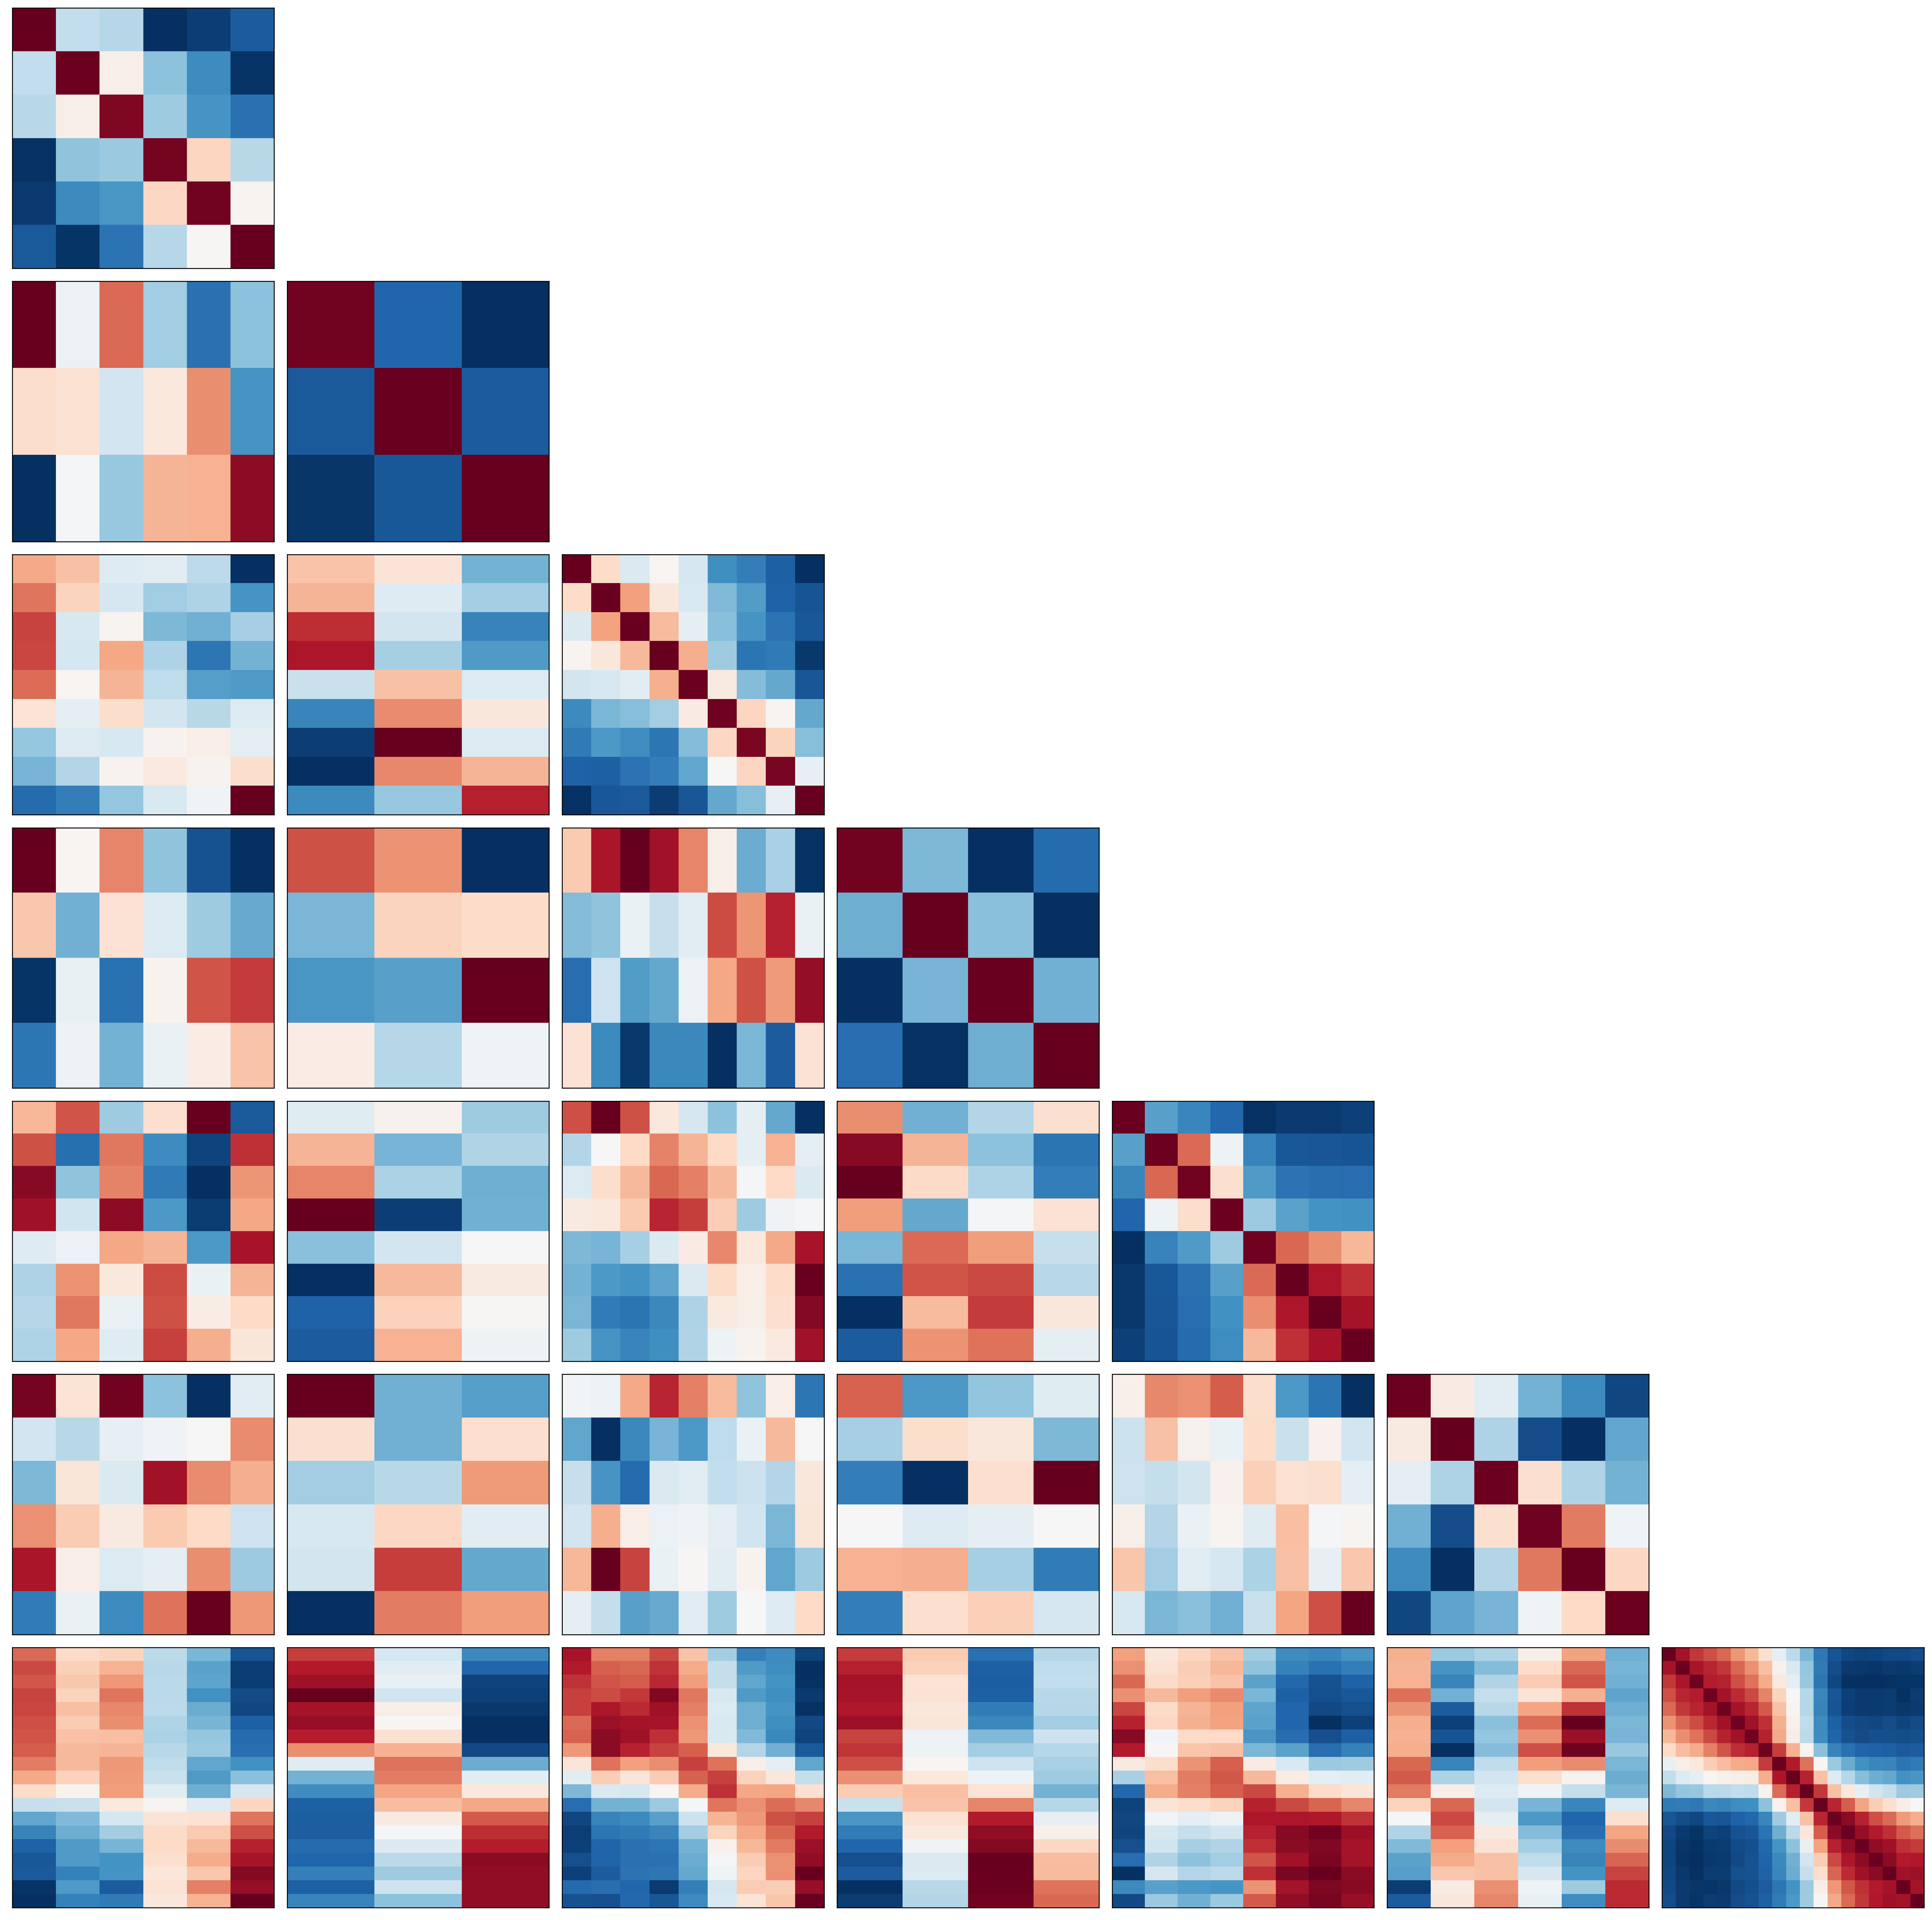

In [85]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(30, 30), nrows=len(assemblies.keys()), ncols=len(assemblies.keys()), dpi=300)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for assembly_1_i, assembly_1 in enumerate(assemblies.keys()):
    for assembly_2_i, assembly_2 in enumerate(assemblies.keys()):
        ax = axes[assembly_1_i, assembly_2_i]

        if assembly_2_i > assembly_1_i: 
            ax.axis('off')
            continue

        df_X_scaled, df_Y_scaled = vals_scaled[(assembly_1, assembly_2)]
        
        # first half
        df_X_scaled = df_X_scaled[df_X_scaled.columns[:len(df_X_scaled.columns) // 2]]
        df_Y_scaled = df_Y_scaled[df_Y_scaled.columns[:len(df_Y_scaled.columns) // 2]]

        # second half
#         df_X_scaled = df_X_scaled[df_X_scaled.columns[len(df_X_scaled.columns) // 2:]]
#         df_Y_scaled = df_Y_scaled[df_Y_scaled.columns[len(df_Y_scaled.columns) // 2:]]

        # scale again
        df_X_scaled.values[:] = sklearn.preprocessing.minmax_scale(df_X_scaled, axis=1)
        df_Y_scaled.values[:] = sklearn.preprocessing.minmax_scale(df_Y_scaled, axis=1)

        corr_matrix = np.zeros((len(df_X_scaled.columns), len(df_Y_scaled.columns)))
        
        for k, c_k in enumerate(df_X_scaled.columns):
            for l, c_l in enumerate(df_Y_scaled.columns):
                corr_matrix[k, l] = stats.spearmanr(df_X_scaled[c_k], df_Y_scaled[c_l])[0]
            
        ax.imshow(corr_matrix, origin='upper', cmap="RdBu_r", interpolation='None', aspect="auto") #,vmin=-1, vmax=1)  
        ax.set_xticks([])
        ax.set_yticks([])
#         if assembly_2_i == 0:
#             ax.set_ylabel(assembly_1, fontsize=18)
#         if assembly_1_i == len(assemblies.keys()) - 1:
#             ax.set_xlabel(assembly_2, fontsize=18)


In [15]:
vals_scaled

{('lancet fish',
  'lancet fish'): (              0         1         2         3         4         5         6  \
  0      0.474050  0.000000  0.179510  0.567919  0.942431  0.826707  0.828766   
  1      1.000000  0.025040  0.883239  0.602956  0.258146  0.161044  0.190094   
  2      0.000000  1.000000  0.156552  0.597090  0.116823  0.159655  0.259685   
  3      1.000000  0.000000  0.501330  0.506841  0.744663  0.680780  0.653796   
  4      0.093714  0.373684  1.000000  0.008920  0.359848  0.075938  0.000000   
  ...         ...       ...       ...       ...       ...       ...       ...   
  11630  0.284156  0.000000  0.710455  1.000000  0.779403  0.558979  0.478521   
  11631  1.000000  0.238742  0.223641  0.000000  0.454589  0.484935  0.497570   
  11632  0.173885  0.036696  1.000000  0.890561  0.799455  0.429528  0.146089   
  11633  0.151873  0.135403  0.133213  0.368033  0.122522  0.112861  0.121194   
  11634  1.000000  0.070280  0.000000  0.249976  0.438862  0.430795  0.4319

In [16]:
df_X, df_Y = vals_scaled[("mouse", "C. elegans")]
df_X = df_X.copy()
df_Y = df_Y.copy()
vals_scaled.keys()

dict_keys([('lancet fish', 'lancet fish'), ('C. elegans', 'lancet fish'), ('C. elegans', 'C. elegans'), ('zebra fish', 'lancet fish'), ('zebra fish', 'C. elegans'), ('zebra fish', 'zebra fish'), ('mouse', 'lancet fish'), ('mouse', 'C. elegans'), ('mouse', 'zebra fish'), ('mouse', 'mouse')])

In [17]:
def get_distance(x, y):
    res = []
    x, y = x.values, y.values
    
    x_rank = x.argsort(axis=1).argsort(axis=1)
    y_max = y.argmax(axis=1)
    nr_columns = x_rank.shape[1]
    for i in range(nr_columns):
        idxs = x_rank[:, i] == 0
#         print(i, np.sum(idxs))
#         if i == 15:
#             print(np.abs(i - y_max[idxs]).mean())
        res.append(np.abs(i - y_max[idxs]).mean())
    return res
    
    
nr_repeats = 50
species_list = ["lancet fish", "C. elegans", "zebra fish"]
dfs_sim = []
dfs_true = []
for species in species_list:
    res = []
    df_X, df_Y = vals_scaled[("mouse", species)]
    df_X = df_X.copy()
    df_Y = df_Y.copy()    

    for _ in range(nr_repeats):
        # randomized with respect to number of "peaks" at each point
        x = df_X.sample(frac=1, axis=0)
        y = df_Y.sample(frac=1, axis=0)

        x = x.reset_index(drop=True)
        y = y.reset_index(drop=True)
        res.append(get_distance(x, y))

    df = pd.DataFrame(res)
    df = pd.melt(df)
    df.columns = ["time point", "average"]
    df["species"] = species
    dfs_sim.append(df)

for species in species_list:
    df_X, df_Y = vals_scaled[("mouse", species)]
    df_X = df_X.copy()
    df_Y = df_Y.copy()    

    df = pd.DataFrame([get_distance(df_X, df_Y)])
    df = pd.melt(df)
    df.columns = ["time point", "average"]
    df["species"] = species
    dfs_true.append(df)
    
    
df_sim = pd.concat(dfs_sim).reset_index(drop=True)
df_true = pd.concat(dfs_true).reset_index(drop=True)

<AxesSubplot:title={'center':'title'}, xlabel='time point', ylabel='average'>

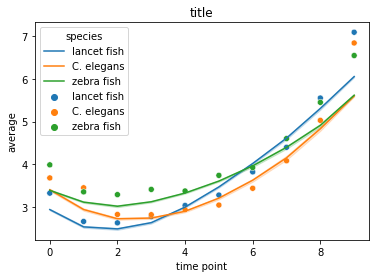

In [18]:
import seaborn as sns


ax = sns.lineplot(
    data=df_sim, 
    x="time point",
    y="average",
    hue="species"
#     ci=None,
).set(title="title")


sns.scatterplot(
    data=df_true, 
    x="time point",
    y="average",
    hue="species"
)

<AxesSubplot:title={'center':'zebra fish'}, xlabel='time point', ylabel='average'>

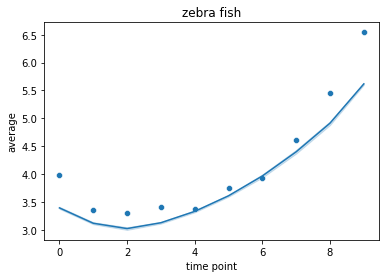

In [19]:
import seaborn as sns

species = "zebra fish"
ax = sns.lineplot(
    data=df_sim[df_sim["species"] == species], 
    x="time point",
    y="average",
#     hue="species"
#     ci=None,
).set(title=species)


sns.scatterplot(
    data=df_true[df_true["species"] == species], 
    x="time point",
    y="average",
)

In [20]:
df_X_scaled, df_Y_scaled = vals_scaled[("C. elegans", "lancet fish")]
# df_X_scaled = df_X_scaled[df_X_scaled.columns[::2]]

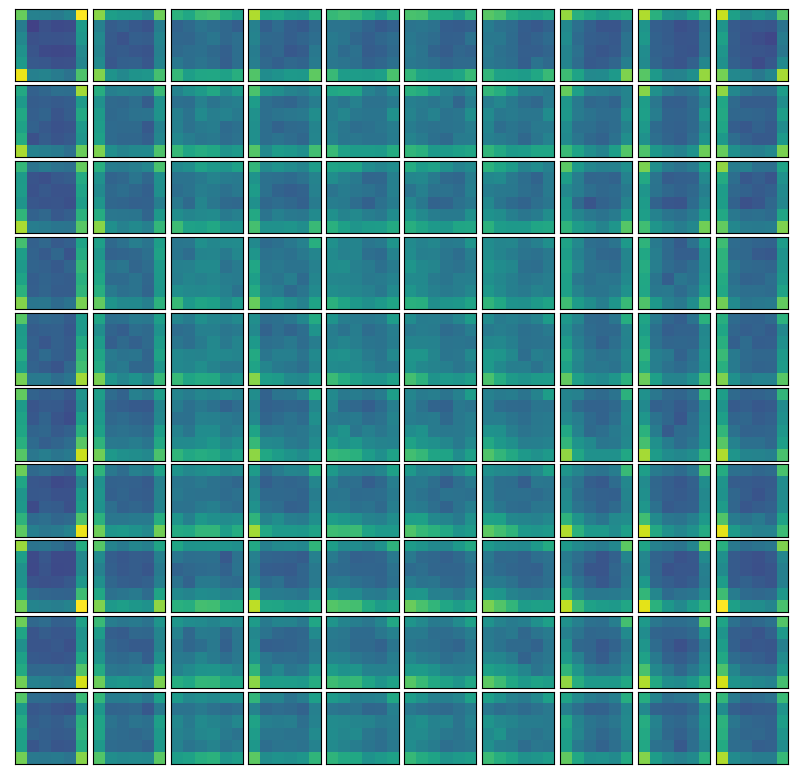

In [21]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(figsize=(len(df_Y_scaled.columns), len(df_X_scaled.columns)), nrows=len(df_X_scaled.columns), ncols=len(df_Y_scaled.columns), dpi=100)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.05)

for i, col_i in enumerate(df_X_scaled.columns):
    for j, col_j in enumerate(df_Y_scaled.columns):
        ax = axes[i, j]

        hist2d, *_ = np.histogram2d(df_X_scaled[col_i], df_Y_scaled[col_j], bins=6, range=[[0, 1], [0, 1]])
        hist2d = np.sqrt(hist2d)
    
        ax.imshow(hist2d, origin='lower', vmin=0, vmax=25)
        ax.set_xticks([])
        ax.set_yticks([])


In [22]:
species = "mouse"
scale = 10


stages = samples.loc[dfs_cpm[species].columns]["hpf"].values
xs = np.linspace(np.min(stages), np.max(stages), 10, dtype=np.float)

df = pd.DataFrame([lss.predict(xs, stderror=False).values for gene_name, r2, lss in fits[species]])
df.index = [gene_name for gene_name, r2, lss in fits[species]]
df.values[:] = sklearn.preprocessing.minmax_scale(df, axis=1)

res = np.zeros(shape=(len(df.columns), scale))

for i, col in enumerate(df.columns):
    vals, xs = np.histogram(df[col], bins=scale)
    res[i, :] = vals    

/tmp/ipykernel_65646/3168202311.py:6: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  xs = np.linspace(np.min(stages), np.max(stages), 10, dtype=np.float)


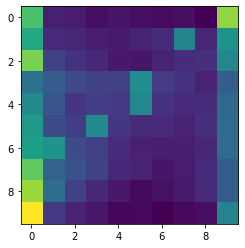

In [23]:
plt.imshow(np.sqrt(res))

In [24]:
xs

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

,0,1,2,3,4,5,6,7,8,9
count,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000,10631.000000
mean,1.436458,1.436458,1.436458,1.436458,1.436458,1.436458,1.436458,1.436458,1.436458,1.436458
std,1.583152,1.583214,1.583212,1.583216,1.583214,1.583216,1.583217,1.583217,1.583213,1.583215
min,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704,-0.146704
25%,0.181766,0.178154,0.156655,0.178011,0.178011,0.178011,0.178011,0.178011,0.178011,0.158468
50%,0.766560,0.766560,0.766560,0.766560,0.766560,0.766560,0.766560,0.766560,0.766560,0.766560
75%,2.275276,2.275276,2.275276,2.275276,2.275276,2.275276,2.275276,2.275276,2.275276,2.275276
max,8.918809,8.918809,8.918809,8.918809,8.918809,8.918809,8.918809,8.918809,8.918809,8.918809


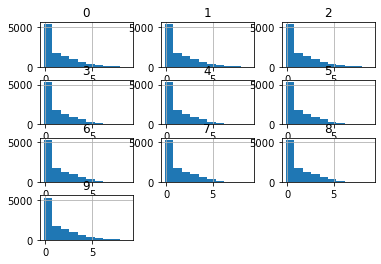

In [25]:
test, *_ = vals_unscaled[("zebra fish", "zebra fish")]
test.hist()
test.describe()

/home/sande/anaconda3/envs/inverse_hourglass/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


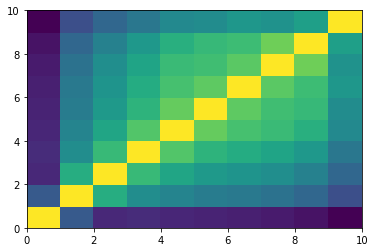

In [26]:
grid = [[None for x in range(10)] for y in range(10)]
for i in range(10):
    for j in range(10):
        grid[i][j] = -jensen_shannon_distance(test[i], test[j])
#         print(i, j, jensen_shannon_distance(test[i], test[j]))
plt.pcolor(grid)

In [27]:
np.array(grid)

array([[-0.        , -0.28712884, -0.35383535, -0.34912388, -0.35589059,
        -0.35957896, -0.36350171, -0.36944641, -0.37831863, -0.39816084],
       [-0.28712884, -0.        , -0.14989934, -0.20463987, -0.21902204,
        -0.23308666, -0.23787189, -0.24732124, -0.26615987, -0.30213718],
       [-0.35383535, -0.14989934, -0.        , -0.1299544 , -0.16381828,
        -0.1836638 , -0.19154565, -0.20225014, -0.22401921, -0.26708832],
       [-0.34912388, -0.20463987, -0.1299544 , -0.        , -0.1088593 ,
        -0.14048818, -0.15374869, -0.16603686, -0.18566433, -0.24000207],
       [-0.35589059, -0.21902204, -0.16381828, -0.1088593 , -0.        ,
        -0.09447699, -0.11732709, -0.12840041, -0.14649596, -0.21035887],
       [-0.35957896, -0.23308666, -0.1836638 , -0.14048818, -0.09447699,
        -0.        , -0.09893678, -0.12171759, -0.13172504, -0.20552537],
       [-0.36350171, -0.23787189, -0.19154565, -0.15374869, -0.11732709,
        -0.09893678, -0.        , -0.10209926

In [28]:
dfs_cpm["C. elegans"].describe()

,GSM1487318,GSM1487319,GSM1487320,GSM1487321,GSM1487322,GSM1487323,GSM1487324,GSM1487325,GSM1487326,GSM1487327,...,GSM1487447,GSM1487448,GSM1487449,GSM1487450,GSM1487451,GSM1487452,GSM1487453,GSM1487454,GSM1487455,GSM1487456
count,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,...,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000,44895.000000
mean,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,...,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257,0.660257
std,1.482978,1.486076,1.488774,1.487260,1.487599,1.487554,1.440843,1.487275,1.487938,1.485500,...,1.488831,1.488772,1.488831,1.488823,1.488812,1.259785,1.488845,1.484614,1.488830,1.488844
min,0.036193,0.023220,0.002879,0.016752,0.014954,0.014329,0.122877,0.016357,0.012440,0.025679,...,0.000075,0.000794,0.000178,0.000568,0.000871,0.306960,0.000000,0.028184,0.000303,0.000008
25%,0.036193,0.023220,0.002879,0.016752,0.014954,0.014329,0.122877,0.016357,0.012440,0.025679,...,0.000075,0.000794,0.000178,0.000568,0.000871,0.306960,0.000000,0.028184,0.000303,0.000008
50%,0.036193,0.023220,0.002879,0.016752,0.014954,0.014329,0.122877,0.016357,0.012440,0.025679,...,0.000075,0.000794,0.000178,0.000568,0.000871,0.306960,0.000000,0.028184,0.000303,0.000008
75%,0.036193,0.023220,0.002879,0.016752,0.014954,0.014329,0.122877,0.016357,0.012440,0.025679,...,0.038232,0.098502,0.049981,0.071040,0.000871,0.306960,0.055500,0.028184,0.053943,0.059412
max,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,...,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466,9.679466
